In [6]:
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm
import seaborn as sns
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings("ignore")


In [7]:
def compute_discrete(signal_u,signal_v):

    invest_u = 100
    invest_v = 100
    cumulative_invest_u = 0
    cumulative_invest_v = 0
    profit_realized_u = 0
    profit_realized_v = 0

    for i in range(0,(signal_u.shape[1])):

        if(signal_u[0][i] == 1):

            cumulative_invest_u += invest_u
            price_paid = dfx_s1['price'].iloc[i]
            stocks_purchased = invest_u/price_paid # invest/price
            while(signal_u[0][i] == 1 and i < signal_u.shape[1] - 1):
                i+=1  
            price_sold = dfx_s1['price'].iloc[i]
            profit_realized_u += (price_sold - price_paid)*(stocks_purchased)

        elif(signal_u[0][i] == -1):

            cumulative_invest_u += invest_u
            price_sold = dfx_s1['price'].iloc[i]
            stocks_sold = (invest_u/price_sold)
            while(signal_u[0][i] == -1 and i < (signal_u.shape[1])-1):
                i+=1
            price_paid = dfx_s1['price'].iloc[i]
            profit_realized_u += (price_sold - price_paid)*(stocks_sold)

    for i in range(0,(signal_v.shape[1])):

        if(signal_v[0][i] == 1):

            cumulative_invest_v += invest_v
            price_paid = dfx_s2['price'].iloc[i]
            stocks_purchased = (invest_v/price_paid)

            while(signal_v[0][i] == 1 and i < signal_u.shape[1] - 1):
                i+=1 
            price_sold = dfx_s2['price'].iloc[i]
            profit_realized_v += (price_sold - price_paid)*(stocks_purchased)

        elif(signal_v[0][i] == -1):

            cumulative_invest_v += invest_v
            price_sold = dfx_s2['price'].iloc[i]
            stocks_sold = (invest_u/price_sold)

            while(signal_v[0][i] == -1 and i < signal_u.shape[1] - 1):
                i+=1
            price_paid = dfx_s2['price'].iloc[i]
            profit_realized_v += (price_sold - price_paid)*(stocks_sold)

    if(cumulative_invest_u == 0 and cumulative_invest_v == 0):
        print("Total Investment in this Trading Period ============> ",(cumulative_invest_v + cumulative_invest_u))
        return

    print("Total Investment in this Trading Period ============> ",(cumulative_invest_v + cumulative_invest_u))
    print("Total Profit/Loss Realized in this Trading Period ==========> ",(profit_realized_u + profit_realized_v))
    res.append(profit_realized_u + profit_realized_v)

    print("Percentage terms =======> ",((profit_realized_u + profit_realized_v)/(cumulative_invest_u + cumulative_invest_v)) + 1)



    

In [8]:
def signal_generation(p_u,p_v):

    signal_u = np.zeros((1,len(p_u)))
    signal_v = np.zeros((1,len(p_v)))

    for i in range(0,len(p_u)):

        if(p_u[i] >= 0.7 and p_v[i] <= 0.3):

            signal_u[0][i] = -1
            signal_v[0][i] = 1

            while(p_v[i] < 0.5 and p_u[i] > 0.5 and i < len(p_u)-1):

                signal_u[0][i] = -1
                signal_v[0][i] = 1
                i+=1

        elif(p_u[i] <= 0.3 and p_v[i] >= 0.7 ):

            signal_u[0][i] = 1
            signal_v[0][i] = -1

            while(p_v[i] > 0.5 and p_u[i] < 0.5 and i < len(p_u)-1):

                signal_u[0][i] = -1
                signal_v[0][i] = 1
                i+=1

    compute_discrete((signal_u),(signal_v))

In [9]:
from sklearn.gaussian_process.kernels import Matern

def Rolling_Window(stocks_2D):

    positions_per_window = []

    for i in range(0,len(stocks_2D) - (trading_period + formation_period),trading_period):

    
        X = stocks_2D[i : i + formation_period, :, :].reshape(formation_period, -1)
        Y = stocks_2D[i + 1 : i + formation_period + 1, :, :].reshape(formation_period, -1)
        X = X[:, ~np.all(np.isnan(X), axis=0)]
        Y = Y[:, ~np.all(np.isnan(Y), axis=0)]
        X = np.where(np.isnan(X), np.nanmean(X, axis=0), X)
        Y = np.where(np.isnan(Y), np.nanmean(Y, axis=0), Y)

        kernel = 63*RBF(length_scale=1) + 0.063**2*RationalQuadratic(length_scale=1.2, alpha=0.78) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.19**2)
        gaussian_process = GaussianProcessRegressor(kernel=kernel,alpha = 1e-10,n_restarts_optimizer=10,normalize_y=False)

        gaussian_process.fit(X, Y)
        kernel_upd = gaussian_process.kernel_
        kernel_upd += WhiteKernel(noise_level=1e-6)  

        probabilities = []
        Prob_U = []
        Prob_V = []
        positions = 0

        for j in range(i+formation_period, i+formation_period+trading_period):
            
            if np.isnan(stocks_2D[j - 1]).any():
                stocks_2D[j - 1] = np.nan_to_num(stocks_2D[j - 1], nan=np.nanmean(stocks_2D[j - 1]))
            if np.isnan(stocks_2D[j]).any():
                stocks_2D[j] = np.nan_to_num(stocks_2D[j], nan=np.nanmean(stocks_2D[j]))

            kernel_matrix = kernel_upd(stocks_2D[j - 1]) 

            bivariate_mean_U = (kernel_matrix[0,1]) * (1/kernel_matrix[0,0]) * stocks_2D[j-1, 1].mean()
            bivariate_mean_V = (kernel_matrix[0,1]) * (1/kernel_matrix[0,0]) * stocks_2D[j-1, 0].mean()

            bivariate_std_dev = kernel_matrix[0][0] - ((kernel_matrix[0][1]) * (1/kernel_matrix[1][1]) * (kernel_matrix[1][0]))

            conditional_probability_U = norm.cdf((stocks_2D[j, 0][0] - bivariate_mean_U) / bivariate_std_dev)

            conditional_probability_V = norm.cdf(
                (stocks_2D[j, 1][0] - bivariate_mean_V) / bivariate_std_dev
            )

            Prob_U.append(np.round(conditional_probability_U,3))
            Prob_V.append(np.round(conditional_probability_V,3))

            if((conditional_probability_U >= 0.7 and conditional_probability_V <= 0.3) or (conditional_probability_U <= 0.3 and conditional_probability_V >= 0.7)):

                positions = positions + 1

            probabilities.append([conditional_probability_U , conditional_probability_V])

        probabilities = np.array(probabilities)
        signal_generation(np.asarray(Prob_U),np.asarray(Prob_V))
        positions_per_window.append(positions)
        dataframe_columns = ['Conditional_Probability_U','Conditional_Probability_V']
        probabilities_df = pd.DataFrame(probabilities,columns=dataframe_columns)

    positions_per_window = np.array(positions_per_window)
    positions_df = pd.DataFrame(positions_per_window)
    print(positions_df)

In [10]:
def rank_normalize_column(column):

    ranks = column.rank(method='average', na_option='keep')
    n = len(column)
    normalized = ranks / (n + 1)
    transformed = 2 * normalized - 1
    transformed_filled = transformed.fillna(0)
    
    return transformed_filled



In [57]:
dfx = pd.read_csv(r"merged_sp500_data.csv")
exclude_columns = ['permno', 'DATE','price']
df1 = dfx[exclude_columns]
cols = dfx.columns.difference(exclude_columns)
dfx = dfx[cols].apply(rank_normalize_column)
dfx = pd.concat([dfx, df1], axis=1)
print(dfx)

         absacc       acc    aeavol       age       agr  baspread      beta   
0      0.277320 -0.329832  0.449281 -0.243293  0.406962 -0.194155 -0.691814  \
1      0.335226 -0.386028  0.334537 -0.243293 -0.227017 -0.750505 -0.731686   
2      0.043531 -0.100796  0.126672  0.486943 -0.382654  0.072163 -0.373221   
3      0.615944 -0.661613 -0.835951 -0.282024  0.881739  0.076726  0.553950   
4     -0.350481  0.272591 -0.811667  0.486943 -0.036070 -0.481716 -0.010811   
...         ...       ...       ...       ...       ...       ...       ...   
42079 -0.659760  0.548889 -0.479743 -0.785292  0.500653  0.715813  0.298562   
42080  0.426375 -0.473755 -0.048069 -0.890911 -0.127551 -0.141214 -0.349222   
42081  0.646311 -0.691410  0.633836 -0.890911  0.346299  0.402590  0.617583   
42082 -0.343828  0.267079 -0.309089 -0.890911 -0.985577 -0.733729 -0.598147   
42083 -0.577949  0.478532  0.407509  0.210621  0.407627  0.066223 -0.682927   

         betasq        bm     bm_ia  ...  std_turn 

In [59]:
dfx['price'].fillna(0)

0         23.059999
1         28.180000
2         20.950001
3         49.619999
4         38.639999
            ...    
42079     26.780001
42080     70.760002
42081    176.770004
42082     81.169998
42083     74.070000
Name: price, Length: 42084, dtype: float64

In [14]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler

def cluster(df,n_clusters = 5):

    features = df.drop(columns=['permno', 'DATE'])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(scaled_features)
    df['cluster'] = clusters

    for cluster_id in df['cluster'].unique():
        cluster_stocks = df[df['cluster'] == cluster_id]
        print(cluster_stocks)




In [15]:
cluster(dfx)

         absacc       acc    aeavol       age       agr  baspread      beta   
0      0.277320 -0.329832  0.449281 -0.243293  0.406962 -0.194155 -0.691814  \
1      0.335226 -0.386028  0.334537 -0.243293 -0.227017 -0.750505 -0.731686   
3      0.615944 -0.661613 -0.835951 -0.282024  0.881739  0.076726  0.553950   
5      0.709374 -0.751574  0.364904 -0.282024 -0.244600 -0.057099 -0.314388   
7      0.457883 -0.504408  0.096353 -0.243293  0.866627 -0.208744 -0.621765   
...         ...       ...       ...       ...       ...       ...       ...   
42072 -0.406677  0.323987 -0.088107 -0.843246 -0.561602  0.307734 -0.665487   
42074 -0.848592  0.704693 -0.199952 -0.868385  0.034525 -0.141262 -0.347559   
42078 -0.162196  0.094998  0.323821 -0.868385 -0.918047  0.660116 -0.002257   
42080  0.426375 -0.473755 -0.048069 -0.890911 -0.127551 -0.141214 -0.349222   
42081  0.646311 -0.691410  0.633836 -0.890911  0.346299  0.402590  0.617583   

         betasq        bm     bm_ia  ...  std_turn 

In [15]:
formation_period = 12
trading_period = 8
feature_list = dfx.columns[2:]


In [104]:
def create_monthly_feature_matrix(dfx, month_index, formation_period, feature_cols):
    """
    Creates a matrix of features for clustering for all stocks at a given month using past 'formation_period' months.
    Each row corresponds to one stock's features over the period, flattened.
    """
    unique_dates = sorted(dfx['DATE'].unique())
    if month_index - formation_period < 0:
        return None  # Not enough history

    # Correct window of exactly 'formation_period' months
    window_dates = unique_dates[month_index - formation_period:month_index]
    df_window = dfx[dfx['DATE'].isin(window_dates)]

    print(f"Creating feature matrix from {window_dates[0]} to {window_dates[-1]}")

    # Pivot table: index = date, columns = (permno, feature), values = feature values
    pivoted = df_window.pivot_table(index='DATE', columns='permno', values=feature_cols)

    # Ensure shape is correct
    if pivoted.shape[0] != formation_period:
        print(f"Warning: only {pivoted.shape[0]} months available instead of expected {formation_period}")
        return None

    # Build feature matrix
    flattened_data = {}
    for permno in pivoted.columns.levels[1]:
        stock_data = pivoted.xs(permno, axis=1, level=1)
        if stock_data.isna().sum().sum() == 0:  # or relax this
            flattened_data[permno] = stock_data.values.flatten()

    feature_matrix = pd.DataFrame.from_dict(flattened_data, orient='index')
    return feature_matrix


In [ ]:
from sklearn.cluster import KMeans
from itertools import combinations
import pandas as pd

def select_pairs_kmeans(feature_matrix, n_clusters=10, n_pairs=20):
    n_samples = feature_matrix.shape[0]
    print(feature_matrix.shape)
    if n_samples < 2:
        # print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        return []  # Not enough stocks to form even one pair

    n_clusters = min(n_clusters, 2)  # Avoid ValueError
    km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = km.fit_predict(feature_matrix)
    clustered = pd.DataFrame({'permno': feature_matrix.index, 'cluster': labels})
    pairs = []

    for cluster_id in clustered['cluster'].unique():
        members = clustered[clustered['cluster'] == cluster_id]['permno'].tolist()
        for pair in combinations(members, 2):
            pairs.append(pair)
            if len(pairs) >= n_pairs:
                return pairs
    return pairs[:n_pairs]


In [66]:
Net_Strategy_PnL = []
for month_idx in range(formation_period, 84 - trading_period):
    feature_matrix = create_monthly_feature_matrix(dfx, month_idx, formation_period, feature_list)
    if feature_matrix is None:
        continue
    res = []
    prev_sum = 0
    try:
        selected_pairs = select_pairs_kmeans(feature_matrix)
    except Exception as e:
        continue
    for permno1, permno2 in selected_pairs:
        
        dfx_s1 = dfx[dfx['permno'] == permno1].reset_index(drop=True)
        dfx_s2 = dfx[dfx['permno'] == permno2].reset_index(drop=True)
        print(permno1,permno2)
        try:
            stock_1 = dfx_s1[feature_list].values
            stock_2 = dfx_s2[feature_list].values
            stocks_3D = np.stack((stock_1, stock_2), axis=2)
            stocks_3D = (stocks_3D - stocks_3D.mean(axis=0)) / stocks_3D.std(axis=0)
            Rolling_Window(stocks_3D)
            print(f"Pairwise PnL:  {sum(res) - prev_sum}")
            prev_sum = sum(res)
        except Exception as e:
            continue
            # print(f"Error with pair ({permno1}, {permno2}): {e}")

    print(f"\n ============= Net Cluster PnL =================:  {sum(res)}\n")
    Net_Strategy_PnL.append(sum(res))
print(f"\n Net Strategy PnL is: {sum(Net_Strategy_PnL)}\n")


20100129 20110131
(4, 1164)
79881 80266
79881 83443
Total Investment in this Trading Period ============>  200
Total Profit/Loss Realized in this Trading Period ==========>  0.0
Percentage terms =======>  1.0
Total Investment in this Trading Period ============>  1000
Total Profit/Loss Realized in this Trading Period ==========>  22.675815763729265
Percentage terms =======>  1.0226758157637292
Total Investment in this Trading Period ============>  1000
Total Profit/Loss Realized in this Trading Period ==========>  16.640663896001534
Percentage terms =======>  1.0166406638960015
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  88.4331012496334
Percentage terms =======>  1.0736942510413612
Total Investment in this Trading Period ============>  400
Total Profit/Loss Realized in this Trading Period ==========>  -16.80712249656368
Percentage terms =======>  0.9579821937585908
Total Investment in this Trading Period ==

KeyboardInterrupt: 

In [65]:
print(sum(Net_Strategy_PnL))
len(Net_Strategy_PnL)

1227.5753453567188


54

In [46]:
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

def evaluate_result(res, F, T):
    returns = np.array(res)
    mean_return = np.mean(returns) if len(returns) > 0 else np.nan
    std_dev = np.std(returns, ddof=1) if len(returns) > 1 else np.nan
    sharpe_ratio = mean_return / std_dev if std_dev != 0 else np.nan
    downside_returns = returns[returns < 0]
    sortino_ratio = mean_return / np.std(downside_returns, ddof=1) if len(downside_returns) > 0 else np.nan
    cumulative_returns = np.cumsum(returns) if len(returns) > 0 else np.array([0])
    rolling_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = rolling_max - cumulative_returns
    max_drawdown = np.max(drawdowns) if len(drawdowns) > 0 else np.nan
    VaR_95 = np.percentile(returns, 5) if len(returns) > 0 else np.nan
    CVaR_95 = np.mean(returns[returns <= VaR_95]) if len(returns) > 0 else np.nan
    skewness = skew(returns) if len(returns) > 0 else np.nan
    kurt = kurtosis(returns) if len(returns) > 0 else np.nan

    metrics = {
        "Mean Return": mean_return,
        "Std Dev": std_dev,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "VaR 95%": VaR_95,
        "CVaR 95%": CVaR_95,
        "Skewness": skewness,
        "Kurtosis": kurt
    }

    print(f"\nEvaluation for F={F}, T={T}")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label="Cumulative Returns", color="blue", linewidth=2)
    plt.fill_between(range(len(cumulative_returns)), cumulative_returns, rolling_max, color='red', alpha=0.3, label="Drawdown")
    plt.axhline(y=VaR_95, color='purple', linestyle="dotted", linewidth=1.5, label="VaR 95%")
    plt.annotate(f"Max Drawdown: {max_drawdown:.4f}", xy=(np.argmax(drawdowns), np.min(cumulative_returns)),
                 xytext=(-50, -30), textcoords='offset points', arrowprops=dict(arrowstyle="->", color="red"),
                 fontsize=10, color="red")
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative PnL")
    plt.title(f"Performance: Formation {F}, Trading {T}")
    plt.legend()
    plt.show()

    return metrics


In [107]:
from sklearn_extra.cluster import KMedoids  # pip install scikit-learn-extra

def select_pairs_kmedoids(feature_matrix, n_clusters=10, n_pairs=20):
    n_samples = feature_matrix.shape[0]
    print(n_samples)
    if n_samples < 2:
        return []

    n_clusters = min(n_clusters, n_samples)
    km = KMedoids(n_clusters=n_clusters, random_state=42, method='pam', init='k-medoids++')
    labels = km.fit_predict(feature_matrix)
    print(labels)
    clustered = pd.DataFrame({'permno': feature_matrix.index, 'cluster': labels})

    pairs = []
    for cluster_id in clustered['cluster'].unique():
        members = clustered[clustered['cluster'] == cluster_id]['permno'].tolist()
        for pair in combinations(members, 2):
            pairs.append(pair)
            if len(pairs) >= n_pairs:
                return pairs
    return pairs[:n_pairs]


In [97]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def plot_kmeans_elbow(feature_matrix, max_k=15):
    wcss = []
    k_range = range(1, max_k + 1)
    n_samples = feature_matrix.shape[0]

    for k in k_range:
        if k > n_samples:
            break  # Can't have more clusters than samples
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(feature_matrix)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(wcss) + 1), wcss, marker='o', linestyle='-')
    plt.title("Elbow Method for Finding Optimal K")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
    plt.grid(True)
    plt.show()


In [109]:
Net_Strategy_PnL = []
for month_idx in range(formation_period, 84 - trading_period):
    feature_matrix = create_monthly_feature_matrix(dfx, month_idx, formation_period, feature_list)
    # plot_kmeans_elbow(feature_matrix)
    if feature_matrix is None:
        continue
    res = []
    prev_sum = 0
    try:
        selected_pairs = select_pairs_kmedoids(feature_matrix)
    except Exception as e:
        continue
    for permno1, permno2 in selected_pairs:
        
        dfx_s1 = dfx[dfx['permno'] == permno1].reset_index(drop=True)
        dfx_s2 = dfx[dfx['permno'] == permno2].reset_index(drop=True)
        print(permno1,permno2)
        try:
            stock_1 = dfx_s1[feature_list].values
            stock_2 = dfx_s2[feature_list].values
            stocks_3D = np.stack((stock_1, stock_2), axis=2)
            stocks_3D = (stocks_3D - stocks_3D.mean(axis=0)) / stocks_3D.std(axis=0)
            Rolling_Window(stocks_3D)
            print(f"Pairwise PnL:  {sum(res) - prev_sum}")
            prev_sum = sum(res)
        except Exception as e:
            continue
            # print(f"Error with pair ({permno1}, {permno2}): {e}")

    print(f"\n ============= Net Cluster PnL =================:  {sum(res)}\n")
    Net_Strategy_PnL.append(sum(res))
print(f"\n Net Strategy PnL is: {sum(Net_Strategy_PnL)}\n")


Creating feature matrix from 20100129 to 20101231
485
[4 4 4 0 5 4 5 1 0 1 0 2 0 5 0 1 0 5 5 3 3 1 5 3 2 3 4 2 3 9 0 5 3 4 0 0 3
 3 6 1 2 1 5 4 4 1 2 5 4 1 0 3 1 3 3 0 4 1 3 3 3 3 4 1 3 4 4 0 4 3 4 0 1 4
 5 2 2 0 0 2 3 4 3 1 2 2 1 5 1 5 2 4 2 0 4 4 1 1 2 4 3 1 0 1 1 4 2 0 0 4 1
 5 1 3 5 4 2 5 5 1 1 0 0 0 5 5 0 2 2 1 3 0 3 0 4 0 5 9 5 2 2 5 3 2 5 3 2 3
 2 2 9 4 2 4 2 2 9 4 3 4 0 5 1 5 3 3 4 1 0 1 2 0 0 3 3 1 4 1 5 2 4 2 4 4 3
 5 2 3 1 1 2 2 5 4 0 3 4 0 2 4 0 5 1 2 2 2 1 5 4 5 2 1 9 2 5 2 8 2 5 2 4 0
 4 5 0 3 1 0 0 2 4 5 0 5 4 2 0 1 5 0 5 1 3 1 4 2 2 4 4 5 3 0 0 0 1 9 1 4 0
 4 9 5 2 4 1 5 4 4 1 2 1 1 1 1 4 1 4 4 2 4 3 0 4 2 0 5 4 4 5 0 5 5 1 2 1 3
 2 4 4 4 1 2 3 0 9 2 4 1 4 4 2 4 6 4 0 2 0 0 2 0 2 4 5 1 5 3 1 4 2 2 0 5 2
 3 4 2 3 5 4 2 4 5 5 1 2 0 4 1 5 2 3 3 2 2 9 2 4 5 3 0 1 5 3 2 5 2 3 3 5 5
 3 1 3 0 4 4 2 2 2 2 3 5 5 4 2 0 0 5 9 2 3 3 2 5 3 1 4 4 1 1 4 1 3 4 5 0 0
 1 2 4 2 0 6 5 9 0 4 0 2 3 1 5 1 3 5 5 2 6 3 5 0 1 0 5 4 3 1 0 0 0 4 0 4 2
 3 6 3 0 1 1 4 0 2 2 9 7 2 4 2 4 9 5 9 1 4 0 6

KeyboardInterrupt: 

Total Net PnL: 21931.45


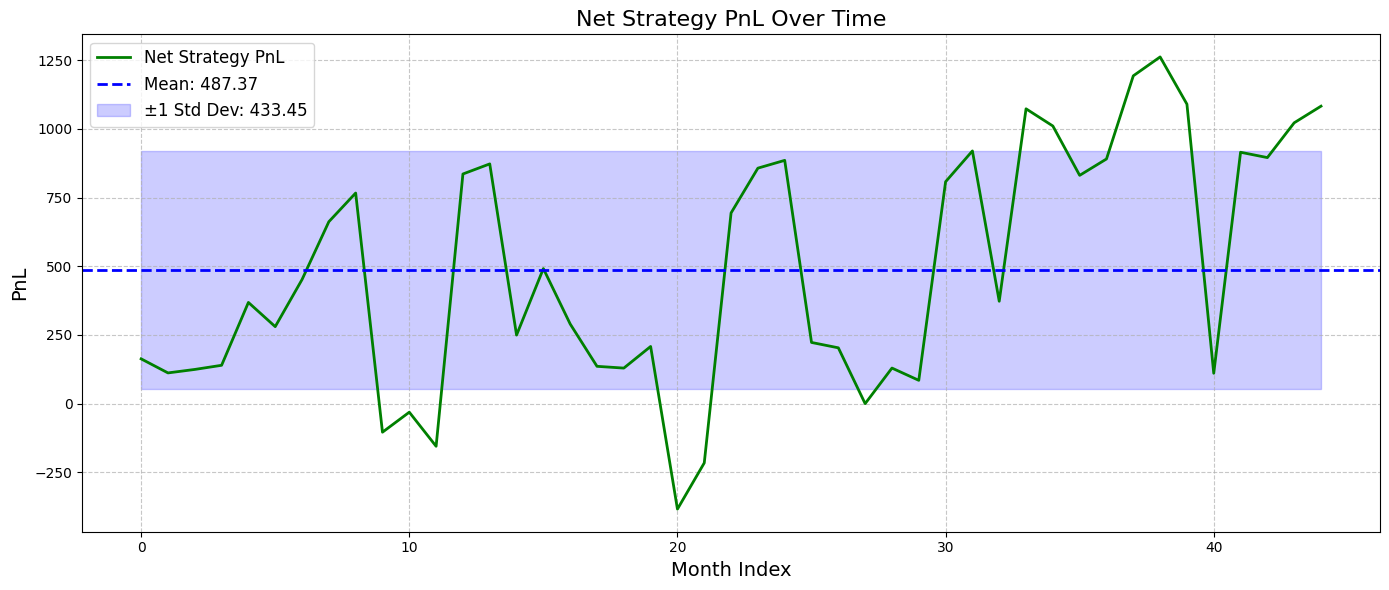

In [113]:
Net_Strategy_PnL = np.array(Net_Strategy_PnL)
mean_pnl = np.mean(Net_Strategy_PnL)
std_pnl = np.std(Net_Strategy_PnL)

plt.figure(figsize=(14, 6))
plt.plot(Net_Strategy_PnL, label='Net Strategy PnL', color='green', linewidth=2)

plt.axhline(mean_pnl, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_pnl:.2f}')
plt.fill_between(range(len(Net_Strategy_PnL)), 
                 mean_pnl - std_pnl, 
                 mean_pnl + std_pnl, 
                 color='blue', 
                 alpha=0.2, 
                 label=f'±1 Std Dev: {std_pnl:.2f}')

plt.title('Net Strategy PnL Over Time', fontsize=16)
plt.xlabel('Month Index', fontsize=14)
plt.ylabel('PnL', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
print(f"Total Net PnL: {Net_Strategy_PnL.sum():.2f}")

plt.show()


In [ ]:
from concurrent.futures import ProcessPoolExecutor
from functools import partial

def process_month(month_idx, dfx, stock_data, feature_list, formation_period):
    res = []
    prev_sum = 0
    try:
        feature_matrix = create_monthly_feature_matrix(dfx, month_idx, formation_period, feature_list)
        if feature_matrix is None:
            return 0

        selected_pairs = select_pairs_kmedoids(feature_matrix)
    except:
        return 0

    for permno1, permno2 in selected_pairs:
        try:
            stock_1 = stock_data[permno1][feature_list].values
            stock_2 = stock_data[permno2][feature_list].values

            if stock_1.shape[0] != stock_2.shape[0]:
                continue

            stocks_3D = np.stack((stock_1, stock_2), axis=2)
            stocks_3D = (stocks_3D - stocks_3D.mean(axis=0)) / stocks_3D.std(axis=0)

            pairwise_pnl = Rolling_Window(stocks_3D)
            res.extend(pairwise_pnl)
        except:
            continue

    return sum(res)


stock_data = {
    permno: df.reset_index(drop=True)
    for permno, df in dfx.groupby("permno")
}

func = partial(process_month, dfx=dfx, stock_data=stock_data,
               feature_list=feature_list, formation_period=formation_period)

Net_Strategy_PnL = []
with ProcessPoolExecutor() as executor:
    results = list(executor.map(func, range(formation_period, 84 - trading_period)))
    Net_Strategy_PnL = results

print(f"\nNet Strategy PnL is: {sum(Net_Strategy_PnL)}")


20150430 20160429


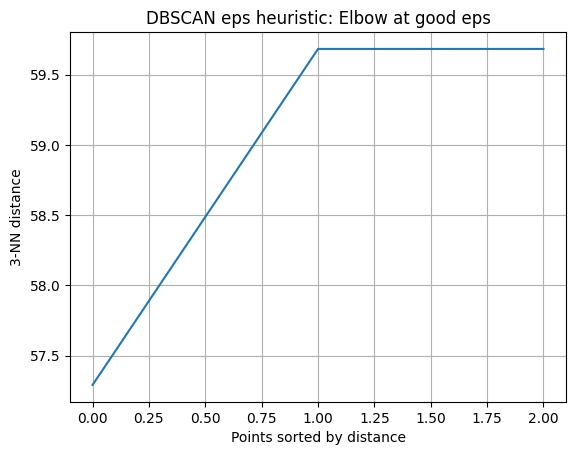

In [77]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
feature_matrix = create_monthly_feature_matrix(dfx, month_idx, formation_period, feature_list)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

def plot_k_distance(features, k=3):
    nbrs = NearestNeighbors(n_neighbors=k).fit(features)
    distances, _ = nbrs.kneighbors(features)
    k_distances = np.sort(distances[:, -1])
    plt.plot(k_distances)
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{k}-NN distance")
    plt.title("DBSCAN eps heuristic: Elbow at good eps")
    plt.grid(True)
    plt.show()

plot_k_distance(scaled_features, k=3)
